The goal is to get the mean square displacement and plot cell movement towards the ablation point. The plot generated here will use a consistent color scheme (viridis) and scale (1-10) so that the colors are comparable when you are plotting different conditions (ie tissues vs single cells).

This code will also generate a table, that will be downloaded, with the mean square displacement of each cell.

**Input:** You need tree things to run this code:

*   A csv table of Centers of Mass (COM) coordinates, originated from the Raju Kada's Macro, uploaded to Google Drive.
*   A csv table with the spot IDs, generated by Trackmate, uploaded to Google Drive.
*   X and Y coordinates for the center of ablation.


Please check the README for how to obtain these from your raw data.


You will need to mount Google Drive if you haven't, logging into your Google account.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Once Drive is mounted, fill out in the code below, where indicated in caps:


*   The coordinates of the center of the ablation
*   The path to your Trackmate table
*   The path to your COM table, generated with Raju Kada's Macro





Table saved as 'displacement_table.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

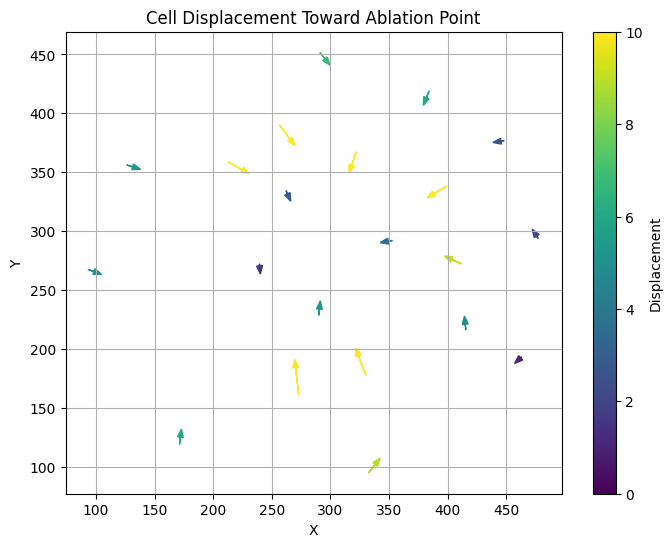

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tabulate import tabulate
import csv
from google.colab import files
import pandas as pd

# Specify the coordinates of the reference point **FILL IN COORDINATES FOR CENTER OF ABLATION POINT HERE (X, Y)**
ref_point = [250,250]

# Read the Trackmate table from Google Drive **FILL IN PATH TO TRACKMATE TABLE HERE**
table1_df = pd.read_csv('/content/drive/My Drive/Tissues/Ti012_trackmate.csv')

# Read the COM table from Google Drive **FILL IN PATH TO CENTER OF MASS (COM) TABLE HERE**
table2_df = pd.read_csv('/content/drive/My Drive/Tissues/Ti012_COM.csv')

# Clean up Trackmate table
table1_df.drop(table1_df.index[1:3], inplace=True)
table1_df = table1_df[['LABEL', 'TRACK_ID', 'POSITION_T']]

# Merge tables
merged_df = pd.merge(table1_df, table2_df, left_on='LABEL', right_on='Label', how='left')
merged_df.reset_index(drop=True, inplace=True)
merged_df = merged_df.iloc[1:]

# Delete cells with incomplete data
merged_df.replace('', np.nan, inplace=True)
merged_df.dropna(subset=merged_df.columns[1:], how='any', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Organize by time and save only first and last timepoints
df = merged_df
df[['xCOM', 'yCOM', 'xCentroid', 'yCentroid', 'Area', 'TRACK_ID', 'POSITION_T']] = df[['xCOM', 'yCOM', 'xCentroid', 'yCentroid', 'Area', 'TRACK_ID', 'POSITION_T']].apply(pd.to_numeric)

filtered_rows = []
for track_id, group in df.groupby('TRACK_ID'):
    max_time_row = group[group['POSITION_T'] == group['POSITION_T'].max()]
    min_time_row = group[group['POSITION_T'] == group['POSITION_T'].min()]
    filtered_rows.append(max_time_row)
    filtered_rows.append(min_time_row)
filtered_df = pd.concat(filtered_rows)

# Clean up table
df2 = filtered_df
df2 = df2.sort_values(by='POSITION_T')
df2 = df2.sort_values(by='TRACK_ID')
columns_to_delete = ['Label', 'LABEL', 'Slice', 'xCentroid', 'yCentroid', 'Area', 'TRACK_ID', 'POSITION_T']
df2 = df2.drop(columns=columns_to_delete)
df2 = df2.rename(columns={'xCOM': 'A', 'yCOM': 'B'})
df2 = df2.dropna(subset=df2.columns, how='all')

# Organize data
df3 = df2
new_data = {
    'xCOM-bef': df3['A'].iloc[::2].reset_index(drop=True),  # Every other row from column A
    'xCOM-aft': df3['B'].iloc[::2].reset_index(drop=True),  # Every other row from column B
    'yCOM-bef': df3['A'].iloc[1::2].reset_index(drop=True), # Remaining rows from column A
    'yCOM-aft': df3['B'].iloc[1::2].reset_index(drop=True)  # Remaining rows from column B
}

new_df = pd.DataFrame(new_data)
new_df['temp'] = new_df['xCOM-aft']
new_df['xCOM-aft'] = new_df['yCOM-bef']
new_df['yCOM-bef'] = new_df['temp']
new_df.drop(columns=['temp'], inplace=True)

# Delete empty cells
df.replace({'': np.nan, ' ': np.nan, 'N/A': np.nan}, inplace=True)
df = df.dropna(axis=0, how='any')

# Extract coordinates
new_df = new_df.iloc[1:]
new_df = new_df.apply(pd.to_numeric)
data = new_df.values.tolist()
x1 = np.array([row[1] for row in data])
x2 = np.array([row[0] for row in data])
y1 = np.array([row[3] for row in data])
y2 = np.array([row[2] for row in data])

# Calculate displacement of each arrow towards ref point, consider only arrows that are pointing to ref point
dx = x2 - x1
dy = y2 - y1
dot_product = ((ref_point[0] - x1) * dx + (ref_point[1] - y1) * dy) / (dx**2 + dy**2)
dot_product = np.clip(dot_product, 0, 1)
projection_x = x1 + dot_product * dx
projection_y = y1 + dot_product * dy
displacement = np.sqrt((projection_x - x1)**2 + (projection_y - y1)**2)

# Define color map for arrows based on displacement length
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=10)  # Adjusted scale from 0 to 10
colors = [cmap(norm(d)) for d in displacement]
#max_displacement = max(displacement)
#norm = plt.Normalize(vmin=0, vmax=max_displacement)

# Create and save a table of displacement values
table_data = [["Arrow", "Displacement"]]
for i in range(len(x1)):
    if dot_product[i] > 0:  # Only consider arrows pointing towards the reference point
        table_data.append([i + 1, f"{displacement[i]:.2f}"])
with open("displacement_table.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerows(table_data)
print("Table saved as 'displacement_table.csv'")
files.download("displacement_table.csv")

# Plot the data
plt.figure(figsize=(8, 6))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Cell Displacement Toward Ablation Point')

# Draw arrows between points with displacement annotation
for i in range(len(x1)):
    if dot_product[i] > 0:  # Only consider arrows pointing towards the reference point
        plt.arrow(x1[i], y1[i], x2[i] - x1[i], y2[i] - y1[i], head_width=5, head_length=7, fc=colors[i], ec=colors[i])

plt.grid(True)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
ax = plt.gca()
plt.colorbar(sm, ax=ax, label='Displacement')
plt.axis('equal')
plt.show()